# <center>Digital Image Processing - Problem Set 3</center>

### Student Names: Daniela Charris Stand & Germán Monsalve Luna

### Instructions

This Problem Set covers the topics of frequency domain filtering and color image processing.<br>

Your solutions to the following problems should include commented source code and a short description of each function. You should test your functions with several input images, besides the ones provided here. Include the input and output images that you used for experimentation. Analyze your results. If you discover something interesting, let us know!

In [2]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import os

### Problem 1

Visualize the Fourier spectrum of an image. Write a function that visualizes the spectrum of an input gray-scale image. The function should perform the following steps:

1. Compute the FFT of the input image using the FFT function <tt>numpy.fft.fft2</tt>.
2. Shift the transform to center the origin in the middle of the image using <tt>numpy.fft.fftshift</tt>.
3. The Fourier transform contains complex numbers, so we usually analyze its phase and spectrum components. Write commands that compute the Fourier spectrum from the shifted Fourier transform.
4. The resulting spectrum is difficult to visualize if plotted directly. Instead, we usually apply a logarithmic intensity transform to the spectrum before visualizing. Use the <tt>numpy.log</tt> function to accomplish this.
5. Plot the modified spectrum.

Test your function by applying it to the images <tt>face.png</tt>, <tt>blown_ic.png</tt>, <tt>test_pattern_blurring_orig.png</tt>, <tt>translated_rectangle.png</tt> and <tt>rectangle.png</tt>.

Please comment your results.

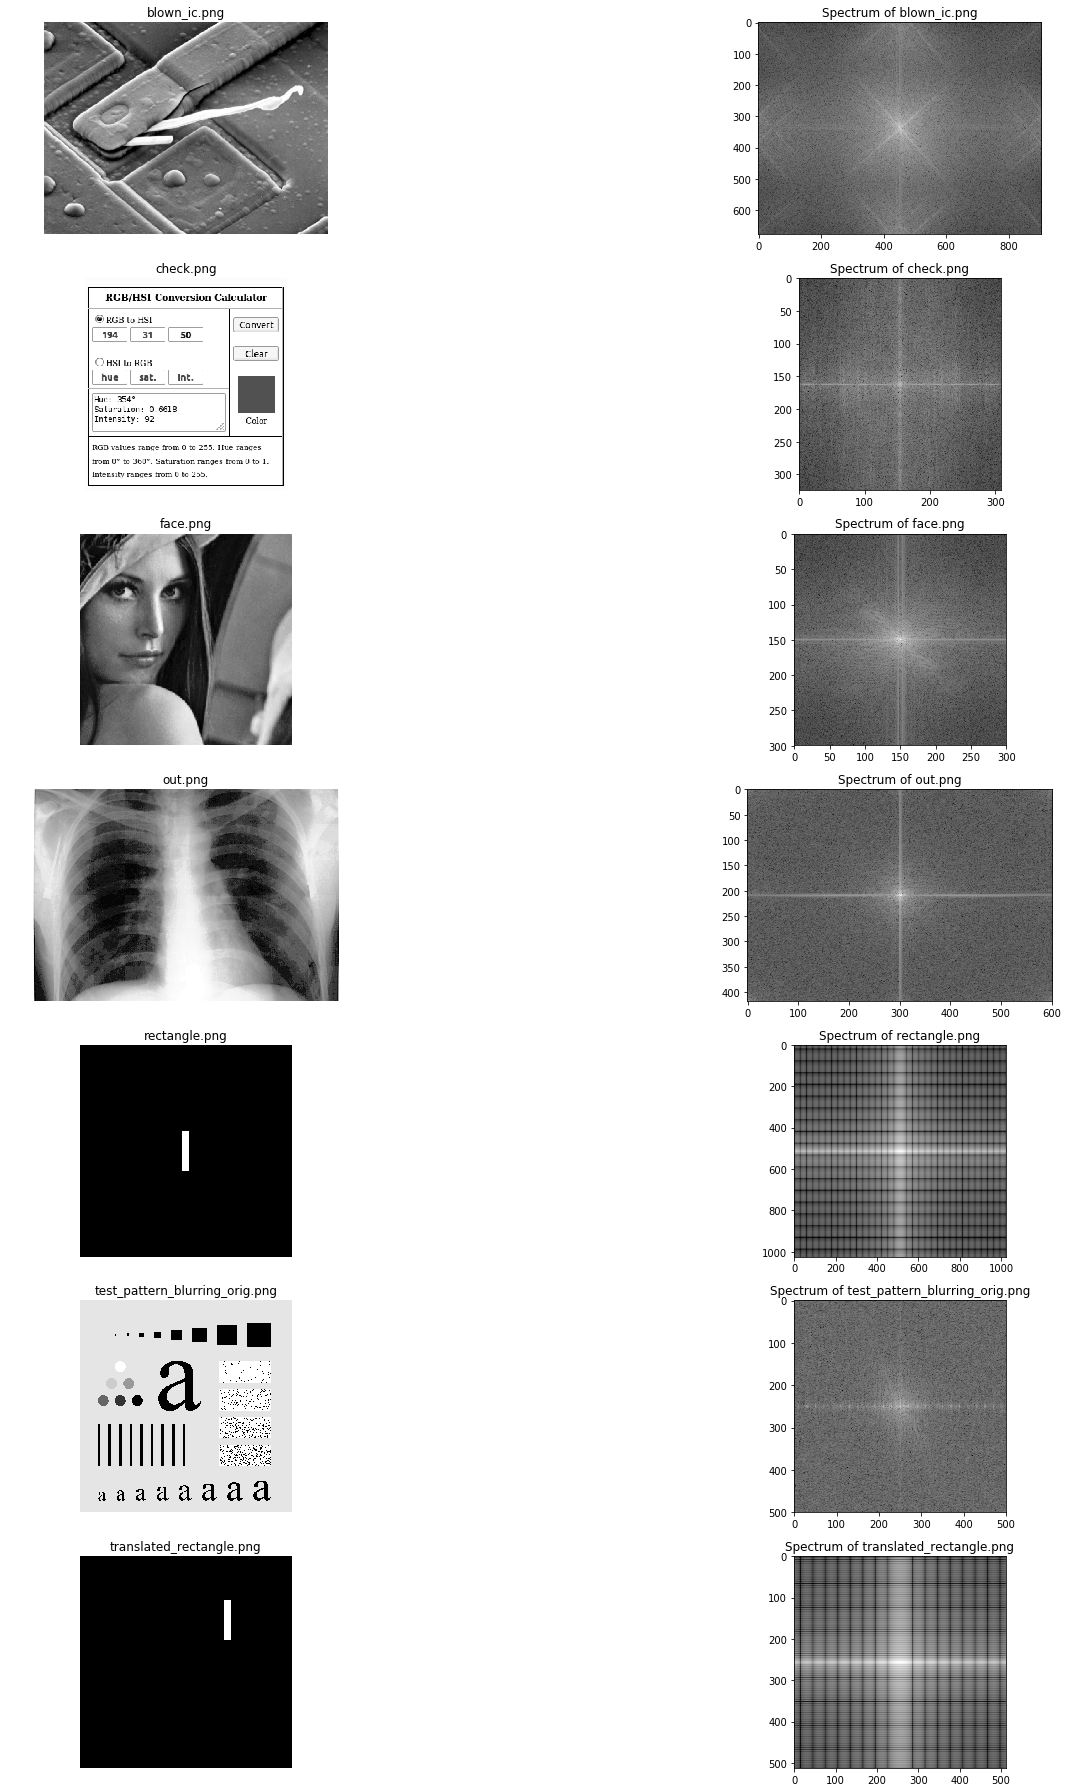

In [55]:
def fftspec(img):
    #Computing FFT
    F=np.fft.fft2(img)
    F=np.fft.fftshift(F)
    #Computing Spectrum, that is the norm of the real and the imaginary part (I**2+R**2)**0.5
    Spectrum=np.absolute(F)
    #creating a log scale
    Spectrum=1+np.log(1+Spectrum)
    return F,Spectrum
i=1
plt.figure(figsize=(25,25))
for filename in os.listdir('images/'):
    #Reading Images
    img = cv2.imread(os.path.join('images/',filename)
                     ,cv2.IMREAD_GRAYSCALE)
    #Plotting Images
    if filename.endswith(".png"):
        if img is not None:
            Fimg,imgSpectrum=fftspec(img)
            plt.subplot(7,2,i);plt.axis('off')
            plt.title(filename)
            plt.imshow(img,cmap='gray')
            i=i+1
            plt.subplot(7,2,i)
            plt.title('Spectrum of %s' % (filename))
            plt.imshow(imgSpectrum,cmap='gray')
            i=i+1
plt.tight_layout()
plt.show()

### Implementación
Para calcular la transformada rápida de Fourier de las imágenes se utilizaron los métodos fft.fft2() y fft.fftshift(). El espectro es la norma de la parte imaginaria y la parte real, la función absolute() realiza esta operación. Por último se usa log() para poder mostrar la fft en escala logarítmica, se suma un 1 en el algoritmo para evitar valores indeterminados, como log(0).
### Resultados
El espectro de la transformada de Fourier de las imágenes nos muestra componentes con el mismo angulo que los bordes de la imagen. Lo anterior se observa claramente en la imagen <tt>blown_ic.png</tt>, en donde el espectro tiene componentes en la misma dirección de los bordes de la imagen, que se encuentran a 45° aproximadamente. También se observa que la transformada de fourier calculada, al ser discreta, es periódica y necesita ser centrada.

### Problem 2

Frequency domain filtering. Write a PYTHON function that performs high-frequency emphasis (hfe) filtering. Recall that an hfe filter is defined as:
\begin{equation}
H_{hfe}(u,v) = a + b \cdot H_{hp}(u,v)
\end{equation}
where $a$ is the offset, $b$ is the high-frequency amplification and $H_{hp}$ is the transfer function of a high-pass filter. Your function should be based on a second-order high-pass Butterworth filter with a cut-off frequency $D_0$, which is given by:
\begin{equation}
H_{hp}(u,v) = \frac{1}{1 + \left[\frac{D_0}{D(u,v)}\right]^{2n}}.
\end{equation}
<b>Note. </b> $D(u,v)$ measures the Euclidean distance from the point $(u,v)$ to the center of the frequency plane.

Use your function and filters on the image <tt>chest.jpg</tt> to reproduce the image enhancement illustrated below.

<img src="images/chest.jpg"/ width=200> <img src="images/out.png"/width=200>

The outline of the process is the following:

1. Create a high-pass Butterworth filter with a frequency domain dimension of 2 times the size of the input image. Plot the filter image.
2. Compute the FFT of the input image using the function <tt>numpy.fft.fft2</tt>. The FFT should have frequency domain dimensions equal to the dimensions of the filter, which should be set using the input parameters of the <tt>fft2</tt> function. Plot the FFT image.
3. Filter the image using the high-pass Butterworth filter. To filter an image in the frequency domain, you should multiply the fourier transform of the image and the frequency response of the filter. To go back to the spatial domain, you need to apply the inverse FFT and take the real component of the resut. Plot the resulting image.
4. Create a high-frequency emphasis filter based on the Butterworth filter of step 1. Plot the filter image.
5. Filter the image using a high-frequency emphasis filter. Plot the resulting image.
6. After filtering, you may need to stretch the intensity values of each resulting image to the range [0, 255]. You can achieve this by substracting the minimum intensity value, dividing by the maximum and multiplying the result by 255.
7. Apply histogram equalization to the image obtained in the previous step. You should obtain a similar result to that shown above.

Use the following parameters for the filters: $a = 0.5$, $b = 2$, $n=2$ and $D_0$ should be set to $5\%$ of the vertical dimension of the filter.

Please comment your results.

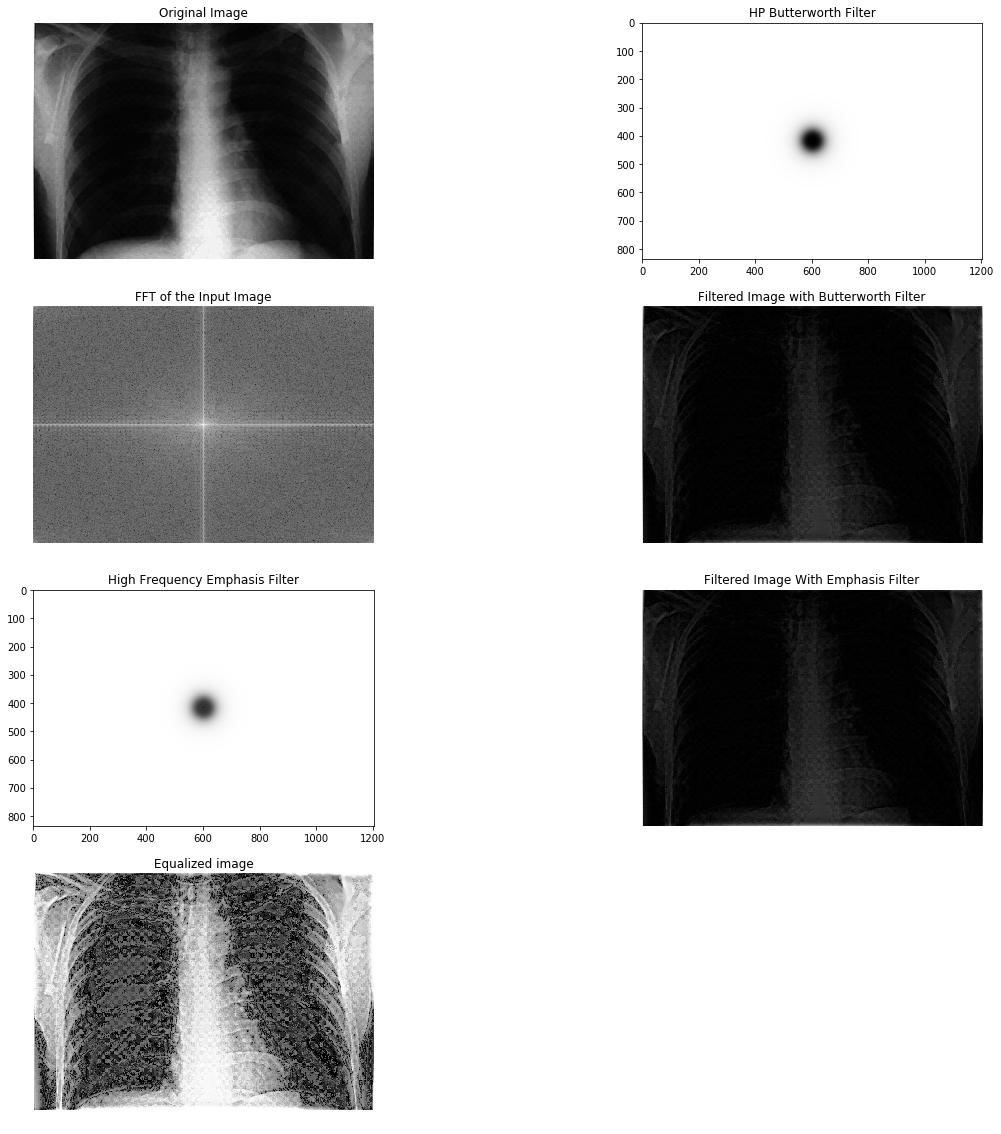

In [59]:
def HPFilter(image, a, b):
    #Normalize the image to CV2_32F to work with float
    imag = np.zeros((np.size(image)))
    imag = cv2.normalize(image,imag, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    imag_h = np.size(imag,0)#Center coordinate in Y
    imag_w = np.size(imag,1)#Center coordinate X
    D0 = 2*imag_h*0.05 #Cutoff frequency is equal to 0.05*(filter's height)

    #Highpass Butterworth Filter
    fil = np.zeros((2*imag_h,2*imag_w))
    for i in range(0,np.size(fil,0)):
        for j in range(0, np.size(fil,1)):
            euc = np.sqrt((i-imag_h)**2+(j-imag_w)**2) #Euclidean distance
            if(euc!=0):
                fil.itemset((i,j), (b /(1.0+((D0/euc)**4))) + a ) #Filter value. Exponent equal to 2*d=2*2=4
    
    #Shifted Fourier Transform with with a frequency domain dimension of the filter
    image_fft = np.fft.fftshift(np.fft.fft2(imag,[2*imag_h,2*imag_w])) 
    
    #Apply highpass filter to the image and return to spatial domain
    mult = np.multiply(image_fft,fil)

    image_filtered = np.abs(np.fft.ifft2(np.fft.ifftshift(mult)))
    output = np.zeros((np.size(imag,0),np.size(imag,0),3))
    output = cv2.normalize(image_filtered[:np.size(imag,0),:np.size(imag,1)],o_simple, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    return fil, image_fft, output


img = cv2.imread("images/chest.jpg", cv2.IMREAD_GRAYSCALE)
# Simple HP filter with a=0 and b=1
a=0;b=1.0;
[filt, img_fft, img_filt] = HPFilter(img,a,b)

# High emphasis filter with a=0.5 and b=2
a=0.5;b=2.0;
[filt2, img_fft, img_filt2] = HPFilter(img,a,b)


#Apply histogram equalization 
emphasis_equ = cv2.equalizeHist(img_filt2) 

plt.figure(figsize=(20,20)) 
plt.subplot(4,2,1);plt.imshow(img,cmap='gray');plt.title('Original Image');plt.axis('off')
plt.subplot(4,2,2);plt.imshow(filt,cmap='gray');plt.title('HP Butterworth Filter');
plt.subplot(4,2,3);plt.imshow(20*np.log(np.abs(img_fft)),cmap='gray');plt.title('FFT of the Input Image');plt.axis('off')
plt.subplot(4,2,4);plt.imshow(img_filt,cmap='gray');plt.title('Filtered Image with Butterworth Filter');plt.axis('off')
plt.subplot(4,2,5);plt.imshow(filt2,cmap='gray');plt.title('High Frequency Emphasis Filter');
plt.subplot(4,2,6);plt.imshow(img_filt2,cmap='gray');plt.title('Filtered Image With Emphasis Filter');plt.axis('off')
plt.subplot(4,2,7);plt.imshow(emphasis_equ,cmap='gray');plt.title('Equalized image');plt.axis('off')

plt.show()

### Implementación
Inicialmente, fue necesario normalizar la imagen para trabajar con datos tipo float. Recorriendo la matriz, se calculó la distancia euclidiana y construyó un filtro de énfasis estándar. El filtro Butterworth cuenta con la característica e tener a=0 y b=1. Posteriormente se utilizaron los métodos fft.fft2() y fft.fftshift() para calcular la Transformada de Fourier de la imagen. Se realizó la multiplicación y con los métodos fft.ifft2() y ftt.isfftshift() se calculó la Transformada Inversa de Fourier. Fue necesario extender nuevamente el rango de valores de la imagen, proceso inverso a normalización para poder graficar.

En lo referente al Filtro de Énfasis, se utilizó la función estándar para los valores de a y b propuestos. De igual forma, se realizó la multiplicación y la transformada de Fourier inversa. Para finalizar, se aplicó la ecualización en la imagen.

### Resultados
Luego de utilizar el filtro Butterworth en la imagen, solo se resalta la silueta de la columna y algunas partes de las costillas, esto nos indica que la mayoría de la información se encuentra en bajas frecuencias. Cuando se aplica el filtro de énfasis, se acentúa el área de las costillas y la columna, eliminando los suavizados y difuminados. Por último, al aplicar la ecualización en la imagen, se observan mejor los detalles, la imagen se ve más clara y acentuada.

### Problem 3

Color spaces. Write a function that converts an image from the RGB color
space to HSI color space. Write another function that converts an image from the HSI
color space to RGB color space. You should use the homework equations to implement these conversions.

When plotting images in the HSI space, you should plot each channel separately, using one image for the H channel, another for the S channel and another for the I channel.

Test your function converting images from RGB to HSI and back to RGB.

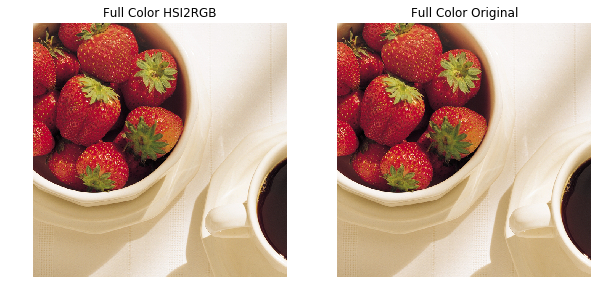

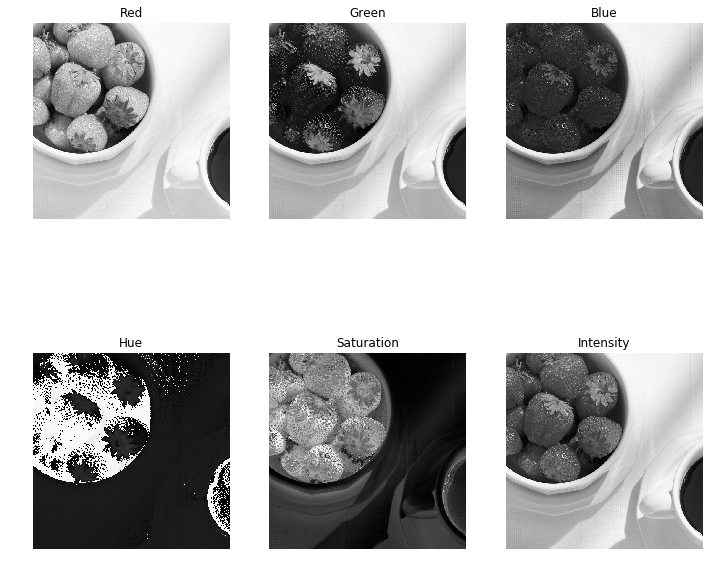

(0.0, 1.0, 0.0, 1.0)

In [60]:
#function that converts an image from RGB to HSI
def RGB2HSI(img):
    #Getting R,G and B
    R=img[:,:,0];G=img[:,:,1];B=img[:,:,2]
    #Normalizing R,G and B
    R=R/255;G=G/255;B=B/255
    H=np.zeros(R.shape)
    S=np.zeros(R.shape)
    I=np.zeros(R.shape)
    #Getting the HSI components Based on the book Digital Image Processing (Gonzalez & Woods)
    #(small number added in the denominator)
    arg=(0.5*((R-G)+(R-B)))/(10**-100+(R-G)**2+(R-B)*(G-B))**0.5
    theta=np.arccos(arg)
    theta=np.rad2deg(theta)
    for row in range(0,H.shape[0]):
        for column in range(0,H.shape[1]):
            #Getting the H component
            if B[row,column]<=G[row,column]:
                H[row,column]=theta[row,column]
            else:
                H[row,column]=360-theta[row,column]
            #Getting the S component 
            #(small number added in the denominator)
            S[row,column]=1-3/(10**-100+R[row,column]+G[row,column]+B[row,column])*min(R[row,column],G[row,column],B[row,column])
    #Getting the I cmponent
    I=1/3*(R+G+B)
    return cv2.merge((H,S,I))
#function that converts an image from HSI to RGB
def HSI2RGB(imghsi):
    H=imghsi[:,:,0]
    S=imghsi[:,:,1]
    I=imghsi[:,:,2]
    #Normalizing HSI components
    Hnorm=H/360
    S=S
    I=I
    #converting H into radians
    Hrad=np.deg2rad(H)
    H120=np.deg2rad(H-120)
    H240=np.deg2rad(H-240)
    #defining R,G,B
    R=np.zeros(H.shape)
    G=np.zeros(H.shape)
    B=np.zeros(H.shape)
    for row in range(0,H.shape[0]):
            for column in range(0,H.shape[1]):
                if 0<=H[row,column]<120:
                    B[row,column]=I[row,column]*(1-S[row,column])
                    R[row,column]=I[row,column]*(1+(S[row,column]*np.rad2deg(np.cos(Hrad[row,column])))/(np.rad2deg(np.cos(60*np.pi/180-Hrad[row,column]))))
                    G[row,column]=3*I[row,column]-(R[row,column] + B[row,column])
                elif 120<=H[row,column]<240:
                    R[row,column]=I[row,column]*(1-S[row,column])
                    G[row,column]=I[row,column]*(1+(S[row,column]*np.rad2deg(np.cos(H120[row,column])))/(np.rad2deg(np.cos(60*np.pi/180-H120[row,column]))))
                    B[row,column]=3*I[row,column]-(R[row,column]+G[row,column])
                elif 240<=H[row,column]<=360:
                    G[row,column]=I[row,column]*(1-S[row,column])
                    B[row,column]=I[row,column]*(1+(S[row,column]*np.rad2deg(np.cos(H240[row,column])))/(np.rad2deg(np.cos(60*np.pi/180-H240[row,column]))))
                    R[row,column]=3*I[row,column]-(G[row,column]+B[row,column])
    return cv2.merge((R,G,B))
                

img=cv2.imread('images/fruits.jpg',cv2.IMREAD_COLOR)
#Converting from BGR to RGB
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imghsi=RGB2HSI(img)
H=imghsi[:,:,0]
S=imghsi[:,:,1]
I=imghsi[:,:,2]
imgrgb=HSI2RGB(imghsi)
R=imgrgb[:,:,0]
G=imgrgb[:,:,1]
B=imgrgb[:,:,2]
#Ploting original and reconverted image 
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(imgrgb)
plt.title('Full Color HSI2RGB');plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img)
plt.title('Full Color Original');plt.axis('off')
plt.show()
#Ploting RGB channels
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(R,cmap='gray');plt.axis('off')
plt.title('Red')
plt.subplot(2,3,2)
plt.imshow(G,cmap='gray');plt.axis('off')
plt.title('Green')
plt.subplot(2,3,3)
plt.imshow(B,cmap='gray');plt.axis('off')
plt.title('Blue')
#Ploting HSI channels
plt.subplot(2,3,4)
plt.imshow(H,cmap='gray');plt.axis('off')
plt.title('Hue')
plt.subplot(2,3,5)
plt.imshow(S,cmap='gray');plt.axis('off')
plt.title('Saturation')
plt.subplot(2,3,6)
plt.imshow(I,cmap='gray');plt.axis('off')
plt.title('Intensity')
plt.tight_layout()
plt.show()
plt.axis('off')

                          
                


### Implementación
Para realizar la conversión de RGB a HSI y de HSI a RGB se consiltó el libro "Digital Image Processing", de Gonzalez y Woods. Para convertir de RGB a HSI se normalizan los tres canales (Rojo, Verde y Azul) para que tomen valores entre de 0 y, luego se desarrolla la conversión pixel por pixel. De igual forma para convertir de HSI a RGB se normaliza la componente H, pues I y S ya se encuentran dentro del rango (de 0 a 1).
### Resultados
Se logro convertir una imagen de RGB a HSI y viceversa. Las imágenes muestras las principales diferencias entre cada uno de los espacios de colores. Esta transformación toma bastante tiempo pues es necesario recorrer toda la imagen pixel por pixel para realizar la transformación. 

### Problem 4

Manipulating color images. Write a function that converts a color image from the RGB to
the HSI color space, modifies the ‘I’ channel by applying histogram equalization, and revert
back the image to the RGB color space. Apply this function to enhance the image <tt>dark_fountain.jpg</tt>.

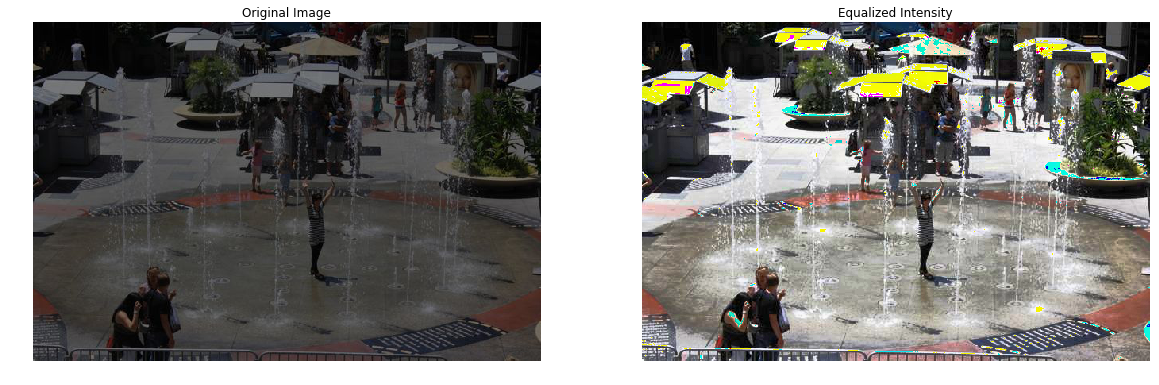

In [62]:
def Iequal(img):
    imghsi=RGB2HSI(img)
    H=imghsi[:,:,0]
    S=imghsi[:,:,1]
    I=imghsi[:,:,2]
    Ieq=np.array(255*I,dtype=np.uint8)
    Ieq=cv2.equalizeHist(Ieq)
    imghsi=cv2.merge((H,S,Ieq/255))
    imgrgb=HSI2RGB(imghsi)
    return imgrgb
img=cv2.imread('images/dark_fountain.jpg',cv2.IMREAD_COLOR)
#Converting from BGR to RGB
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imgeq=Iequal(img)
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original Image');plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(imgeq)
plt.title('Equalized Intensity');plt.axis('off')
plt.show()
       

### Implementación 
Se utilizaron las funciones definidas en el problema anterior. Para realizar la ecualización de histograma del canal I se utilizo la función de opencv equalizeHist(). Como se explico anteriormente el canal I presenta valores entre 0 y 1, por tanto es necesario multiplicarlo por 255 y redondear el resultado a un entero de 8 bits para realizar la equalización de histograma. 
### Resultados
Al ecualizar el histograma del canal I se observa que se mejora el brillo de la imagen.

### Problem 5 

Manipulating color images. Consider the RGB color image <tt>squares.jpg</tt>, where the
squares are pure red, green and blue.

<img src="files/squares.jpg" width=200 />

1. Convert this image to the HSI color space. Blur the H component of the image using a 25x25 averaging mask, and convert it back to RGB. How do you explain the obtained result?
2. Repeat, blurring only the saturation component this time. How do you explain the result?


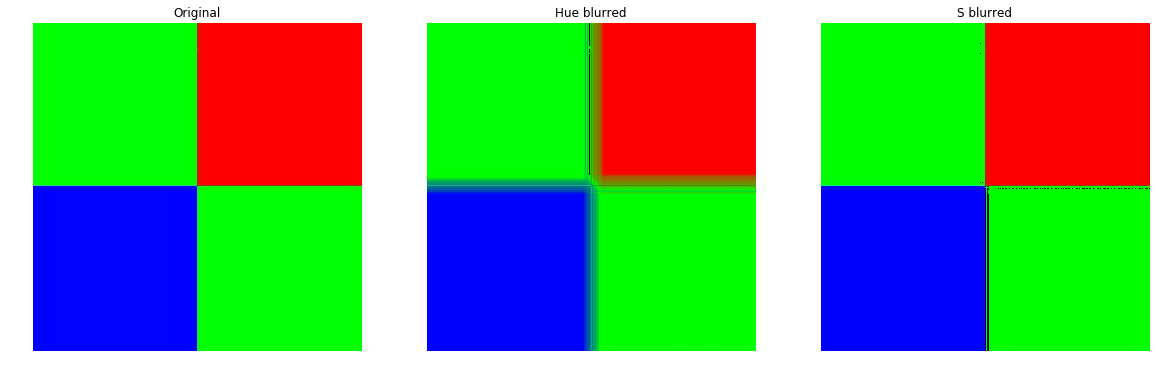

In [63]:
img=cv2.imread('images/squares.jpg',cv2.IMREAD_COLOR)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imghsi=RGB2HSI(img)
H=imghsi[:,:,0]
S=imghsi[:,:,1]
I=imghsi[:,:,2]
#using cv2.blur
Hblur=np.zeros(H.shape)
Hblur=cv2.blur(H,(25,25))
Sblur=np.zeros(S.shape)
Sblur=cv2.blur(S,(25,25))
imgHblur=HSI2RGB(cv2.merge((Hblur,S,I)))
imgSblur=HSI2RGB(cv2.merge((H,Sblur,I)))
# Results
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original');plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(imgHblur)
plt.title('Hue blurred');plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(imgSblur)
plt.title('S blurred');plt.axis('off')
plt.show()

### Implementación
Se utilizaron la función HSI2RGB y RGB2HSI definidas en el problema 3. Además, se utilizó la función .blur() que permite realizar el filtro en los canales H y S.

### Resultados
La imagen en donde se difuminó el canal H, presenta cambios significativos en los bordes esto se debe a que en los bordes el kernel de 25X25 cambia el valor del ángulo de H, por tanto se observa entonces un cambio en la imagen RGB. Para el difuminado en el canal S, que indica que tan "claro" o "oscuro" es un color, se obcerva que para esta imagen todos los colores tienen casi misma "saturación", por tanto no se aprecia un cambio significativo en la imagen. 

## Problem 6

False color. Write a Python function that produces a false color visualization of
the input gray-scale image as follows:

1. If the intensity of an input pixel is lower than a threshold $T$, then the color of the corresponding pixel should be blue.
2. If the intensity of an input pixel is larger or equal than a threshold $T$, then the color of the corresponding pixel should be yellow.

Use your function to reproduce the following result on the image <tt>weld_x-ray.jpg</tt>:

<img src="images/weld_x-ray.jpg" width=200 /> <img src="images/Fig6.21(b).jpg" width=200 /> 

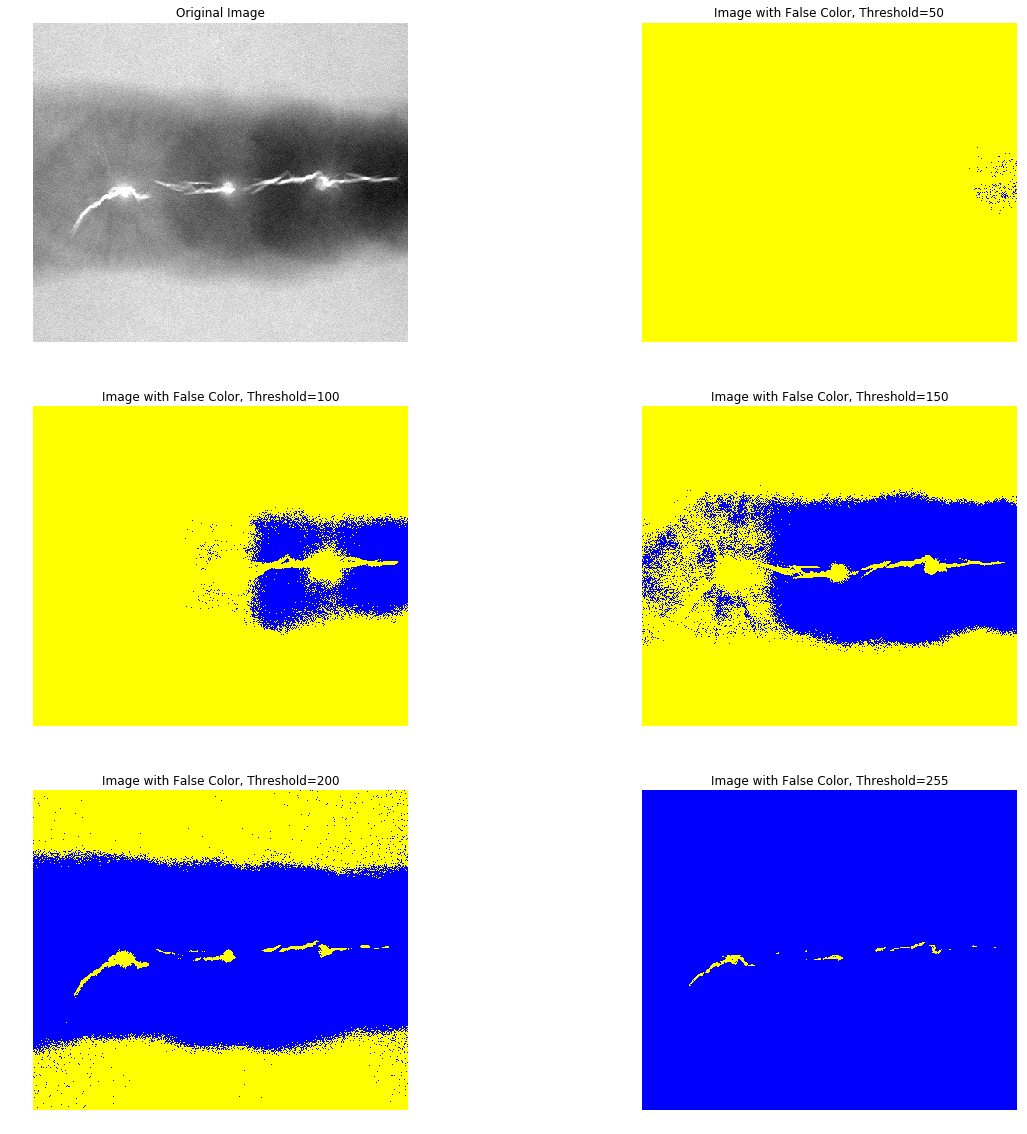

In [64]:
#Function for the false color visualization
def falseColor(image, T):
    #Creating each channel 
    R = np.zeros((np.size(image,0),np.size(image,1)),dtype=np.uint8) 
    G = np.zeros((np.size(image,0),np.size(image,1)),dtype=np.uint8)
    B = np.zeros((np.size(image,0),np.size(image,1)),dtype=np.uint8)

    #Evaluate each pixel 
    for i in range(0,np.size(image,0)):
        for j in range(0, np.size(image,1)):
            if (image[i,j]<T):
                #If the intensity is lower than T, put in Blue matrix
                B[i,j] = 255
            else:
                #If the intensity is higher or equal than T, put in Green and Red matrix
                #Yellow = Green + Red 
                G[i,j] = 255
                R[i,j] = 255
    image_f = np.dstack((R,G,B)) # Put each matrix in one array
    return image_f

img = cv2.imread('images/weld_x-ray.jpg',cv2.IMREAD_GRAYSCALE)
vector_T = [50,100,150,200,255] #Vector of different threshold values
plt.figure(figsize=(20,20)) 
plt.subplot(3,2,1);plt.imshow(img,cmap='gray');plt.title('Original Image');plt.axis('off')
l=2
for i in range(len(vector_T)):
    img_f = falseColor(img,vector_T[i]) #Calling the function
    plt.subplot(3,2,l);plt.imshow(img_f);plt.title('Image with False Color, Threshold='+str(vector_T[i]));plt.axis('off')
    l = l+1 #For the subplot
plt.show()

### Implementación
Teniendo en cuenta que es una imagen en escala de grises, se evaluó cada uno de los pixeles con diferentes valores de Threshold. Se crearon 3 matrices para cada uno de los canales R,G y B. En caso tal de que el píxel sea mayor al valor de Threshold, se llena la matriz del color azul para ese píxel en el máximo valor (255), en caso contrario, se llenan las matrices de color verde y rojo, dado que el amarillo es la suma de los dos colores. Por último, se utiliza el método dstack para concatenar las 3 matrices y graficar.

### Resultados
Se observó que a medida que se aumentaba el valor de Threshold, mayor era el área azul, llegando a que con un valor de Threshold de 255 se obtiene la imagen deseada en el inciso.

## Problem 7

Green screen effects. Write a function that replaces the green background of the image <tt>hiro.jpg</tt> with a background image of your choice.

<img src="images/hiro.jpg" width=300>

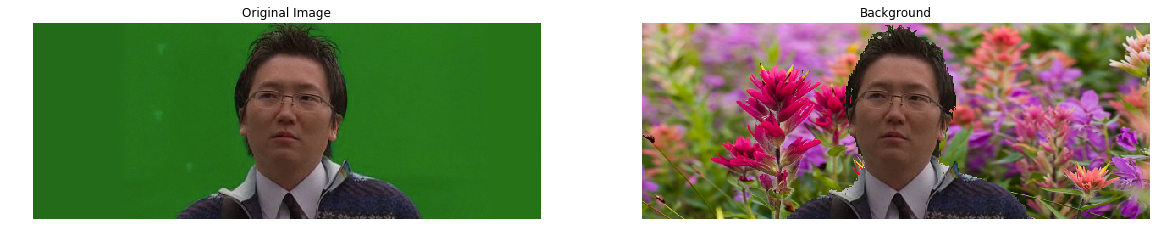

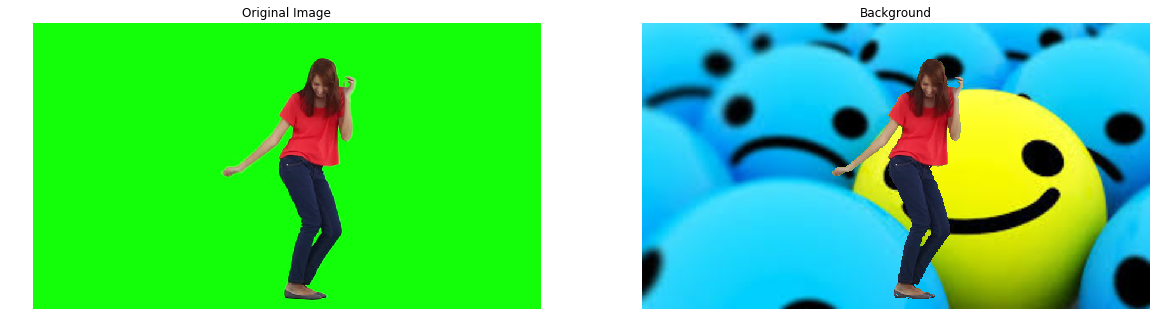

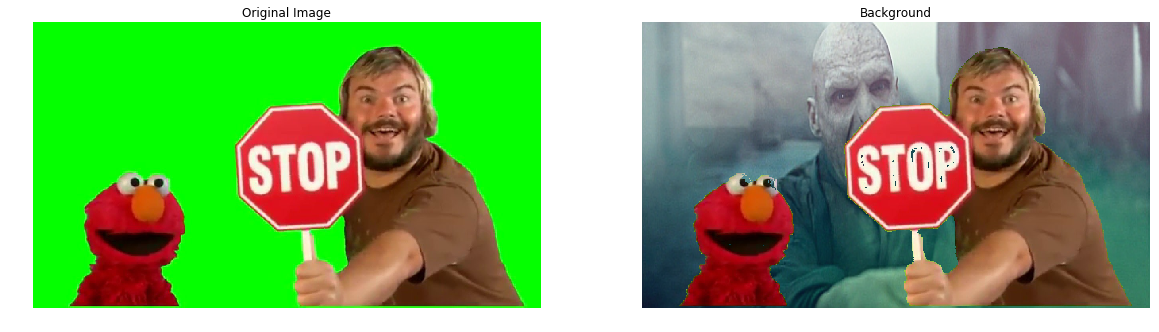

In [54]:
#Function
def replaceGB(image,bg):
    #Convert RGB to HSI
    img_hsi = RGB2HSI(image)
    #Split each component (H,S,I)
    H=img_hsi[:,:,0]
    S=img_hsi[:,:,1]
    I=img_hsi[:,:,2]

    #Resize Background to Image's resolution
    bg = cv2.resize(bg,(np.size(image,1),np.size(image,0)))

    #Creating image
    image_GB = np.zeros((np.size(image,0),np.size(image,1),np.size(image,2)))

    #Evaluate each pixel 
    for i in range(0,np.size(image,0)):
        for j in range(0, np.size(image,1)):
            if ((H[i,j])>90 and (H[i,j]<150)):
                #If the Hue is between 90 degrees and 150 degrees (Green section)
                #Replace with background
                image.itemset((i,j,0),bg.item(i,j,0))
                image.itemset((i,j,1),bg.item(i,j,1))
                image.itemset((i,j,2),bg.item(i,j,2))

    image_GB = image
    
    return image_GB

#FIRST IMAGE
img = cv2.imread('images/hiro.jpg',cv2.IMREAD_COLOR)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

backg = cv2.imread('images/flower.jpg',cv2.IMREAD_COLOR)
backg = cv2.cvtColor(backg,cv2.COLOR_BGR2RGB)


plt.figure(figsize=(20,20)) 
plt.subplot(1,2,1);plt.imshow(img);plt.title('Original Image');plt.axis('off')
img_gb = replaceGB(img,backg)
plt.subplot(1,2,2);plt.imshow(img_gb);plt.title('Background');plt.axis('off')
plt.show()

#SECOND IMAGE
img2 = cv2.imread('images/image_gb1.jpg',cv2.IMREAD_COLOR)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

backg2 = cv2.imread('images/bg_1.jpg',cv2.IMREAD_COLOR)
backg2 = cv2.cvtColor(backg2,cv2.COLOR_BGR2RGB)


plt.figure(figsize=(20,20)) 
plt.subplot(1,2,1);plt.imshow(img2);plt.title('Original Image');plt.axis('off')
img_gb2 = replaceGB(img2,backg2)
plt.subplot(1,2,2);plt.imshow(img_gb2);plt.title('Background');plt.axis('off')
plt.show()

#THIRD IMAGE
img3 = cv2.imread('images/image_gb2.jpg',cv2.IMREAD_COLOR)
img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)

backg3 = cv2.imread('images/bg_2.jpg',cv2.IMREAD_COLOR)
backg3 = cv2.cvtColor(backg3,cv2.COLOR_BGR2RGB)


plt.figure(figsize=(20,20)) 
plt.subplot(1,2,1);plt.imshow(img3);plt.title('Original Image');plt.axis('off')
img_gb3 = replaceGB(img3,backg3)
plt.subplot(1,2,2);plt.imshow(img_gb3);plt.title('Background');plt.axis('off')
plt.show()



### Implementación
Para reemplazar el fondo verde se utilizó la función RGB2HSI definida en incisos anteriores. Teniendo en cuenta que en la escala HSI, H es el ángulo del vector S, y que el verde está representado aproximadamente dentro de los ángulos 90 y 150, se cambiaron los pixeles donde el ángulo estuviera dentro de 90 y 150 por el valor del píxel del fondo a utilizar. Cabe destacar que se utilizó el método .itemset como una manera más práctica de reemplazar los píxeles de una imagen.
### Resultados
En el fondo verde se utilizó un rango de grados de amplitud 60°, lo cual permitió realizar el cambio de fondo en las imágenes de manera satisfactoria, ante diferentes tonos de verde.